In [1]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from skimage.filters import difference_of_gaussians
from skimage.filters import gabor_kernel
import feature_extraction.gabor
from feature_extraction.gabor import GaborKernel
import importlib
importlib.reload(feature_extraction.gabor)
from feature_extraction.gabor import GaborKernel
from scipy import ndimage as ndi
from scipy.signal import convolve2d

In [2]:
names=[]
a = np.zeros((20,72), dtype=object)
for dirname, _, filenames in os.walk('C:/Users/ehajizad/Projects/data/coil-20/coil-20-proc'):
    proc_dirname = dirname
    for ind, filename in enumerate(filenames):
        names.append(filename)

In [3]:
import tempfile, os, shutil, cv2, re
from datasets.general.utils import imreadBGR
data, label = [], []

for name in names:
    if bool(re.search('obj', name)):
        img = cv2.imread(os.path.join(proc_dirname, name),0)
        data.append(img)
        label.append(int(name.split("__")[0].split("obj")[1]))

<IPython.core.display.Javascript object>


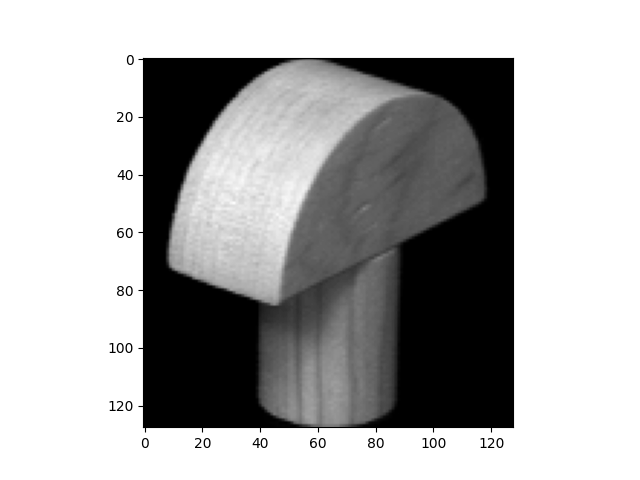

In [4]:
plt.imshow(data[90], cmap='gray', vmin=0, vmax=255)
plt.show()

In [4]:
data = np.stack(data, axis=0).transpose([0, 1, 2])
label = np.array(label).astype(np.uint8)
print("data shape: ", data.shape, "\nlabel shape:", label.shape)

data shape:  (1440, 128, 128) 
label shape: (1440,)


In [5]:
label = label - 1
sorted_inds = np.argsort(label)
label = label[sorted_inds]

In [28]:
dog_img = np.zeros(shape=data.shape)
for i in range(data.shape[0]):
    dog_img[i,:,:] = difference_of_gaussians(data[i,:,:], 1.5)
dog_img[dog_img<0]=0
dog_img.shape

(1440, 128, 128)

In [7]:
gabors = []
n_filters = 8
width = 27
for i in range(n_filters):
    gabors.append(GaborKernel(sigma=3, width=width, theta=i*np.pi/8, lamda=8, gamma=0.5, psi=0))
gabor_filters = np.zeros(shape=(n_filters,gabors[0].weights.shape[0], gabors[0].weights.shape[1]))
for i in range(n_filters):
    gabor_filters[i,:,:] = gabors[i].weights
print("shape of filters tensor: ", gabor_filters.shape )

shape of filters tensor:  (8, 27, 27)


In [ ]:
n_samples = dog_img.shape[0]
img_width = dog_img.shape[1]
n_filters=8
filtered = np.zeros((n_filters, n_samples, img_width, img_width))
for f in range(n_filters):
    afilter = np.expand_dims(gabor_filters[f,:,:], 0)  
    filtered[f,:,:,:] = ndi.convolve(dog_img, afilter, mode='wrap')
filtered.shape

In [32]:
filtered = np.swapaxes(filtered, 0,1)
flat_features = filtered.reshape((filtered.shape[0], filtered.shape[1]*filtered.shape[2]*filtered.shape[3]))
flat_features.shape

In [64]:
filtered = filtered[sorted_inds,...]

In [67]:
with open('C:/Users/ehajizad/lava-nc/neuromorphic-continual-learning/tutorials/filtered_coil20.npy', 'wb') as f:
    np.save(f,filtered)

In [68]:
with open('C:/Users/ehajizad/lava-nc/neuromorphic-continual-learning/tutorials/coil20_labels.npy', 'wb') as f:
    np.save(f,label)

In [60]:
s = 3
n_samples = dog_img.shape[0]
img_width = dog_img.shape[1]
n_filters=8
ft_width = int((img_width-width)/s + 1)
stride_filtered = np.zeros((n_filters, n_samples, ft_width, ft_width))

for f in range(n_filters):
    reversed_filter = gabor_filters[f,:,:]#[::-1, ::-1]
    for n in range(n_samples):   
        stride_filtered[f,n,:,:] = convolve2d(dog_img[n,:,:], reversed_filter, 'valid')[::s, ::s]


In [61]:
stride_filtered = np.swapaxes(stride_filtered, 0,1)
flat_st_feat = stride_filtered.reshape((stride_filtered.shape[0],
                                        stride_filtered.shape[1]*stride_filtered.shape[2]*stride_filtered.shape[3]))
flat_st_feat.shape

(1440, 9248)

In [39]:
stride_filtered = stride_filtered[sorted_inds,...]

In [66]:
with open('C:/Users/ehajizad/lava-nc/neuromorphic-continual-learning/tutorials/strided_coil20.npy', 'wb') as f:
    np.save(f,stride_filtered)

<IPython.core.display.Javascript object>


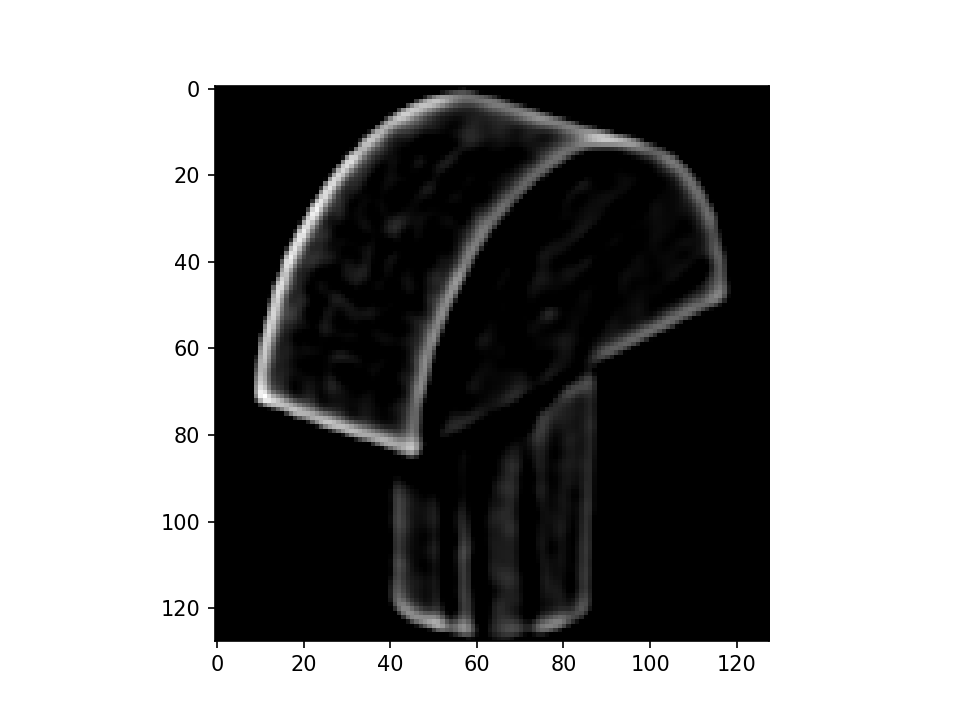

In [59]:
img = dog_img[90,:,:]
fig = plt.figure()
# img[img<0] = 0
plt.imshow(img, cmap='gray')
plt.show()

<IPython.core.display.Javascript object>


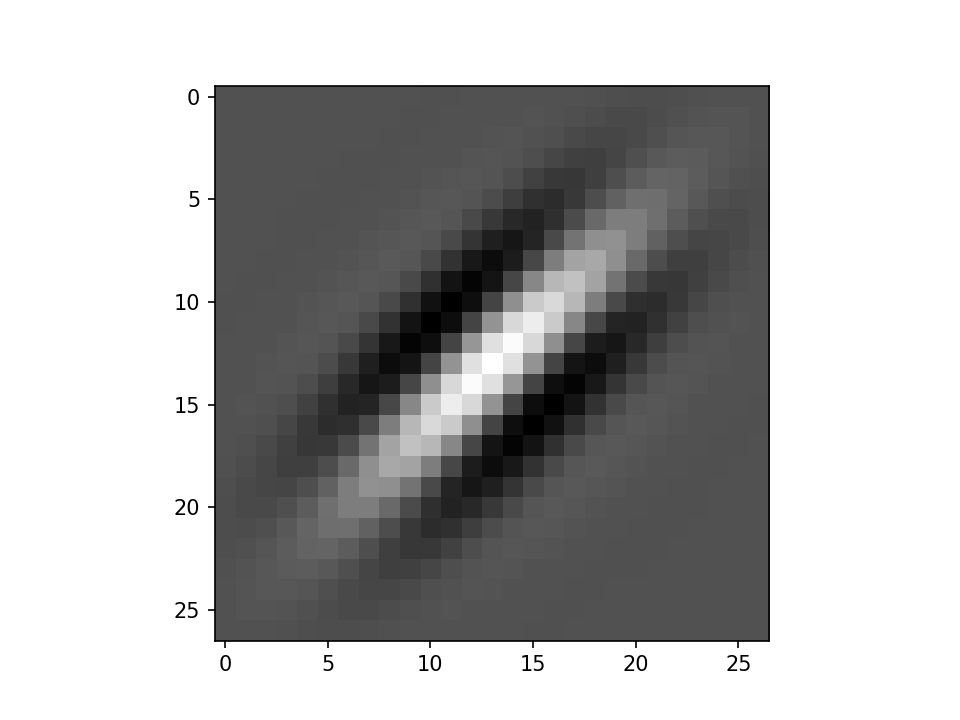

<IPython.core.display.Javascript object>


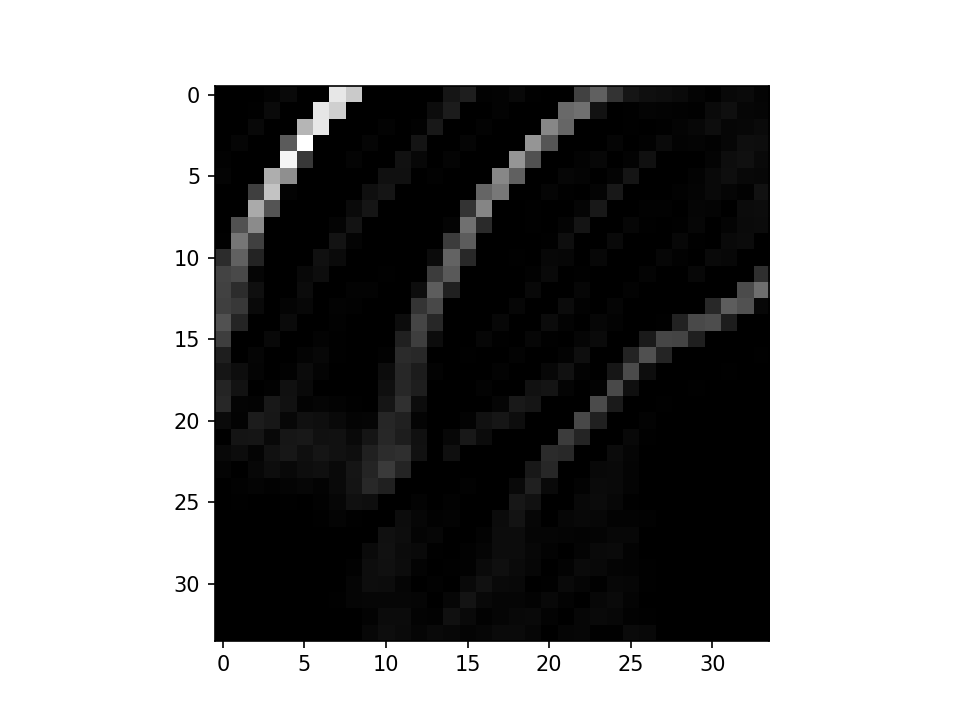

In [58]:
f = 2
plt.figure()
plt.imshow(gabor_filters[f,:,:], cmap='gray')

plt.figure()
s = 3
n_samples = dog_img.shape[0]
img_width = dog_img.shape[1]
ft_width = int((img_width-width)/s + 1)
reversed_filter = gabor_filters[f,:,:][::-1, ::-1]
img = convolve2d(dog_img[90,:,:], reversed_filter, 'valid')[::s, ::s]
img[img<0]=0
plt.imshow(img, cmap='gray')
plt.show()

<IPython.core.display.Javascript object>


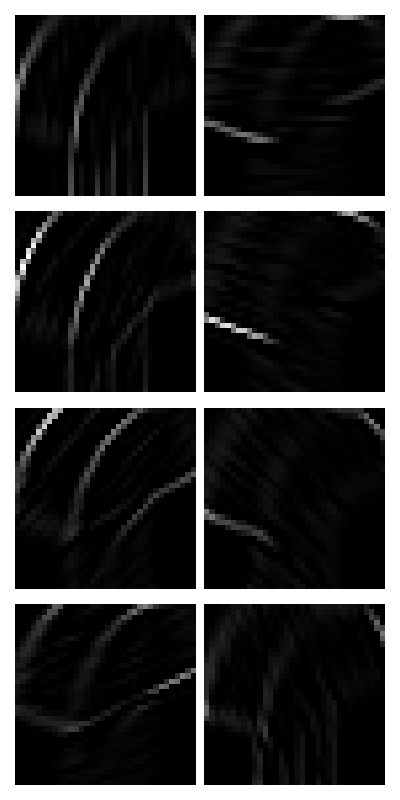

In [113]:
fig, axes = plt.subplots(4, 2, figsize=(4,8))
axes = axes.flatten(order='F')
for i in range(8):
    filt_img = stride_filtered[90,i,:,:]
    filt_img[filt_img<0]=0
    
    plt.sca(axes[i])
    plt.imshow(filt_img, cmap='gray', vmin=0, vmax=2)
    plt.axis('off')
#     gabors[i].plot()
plt.tight_layout()
plt.show()

In [131]:
patch = stride_filtered[90,:,:,:]
a = np.argwhere(patch>0.89 )
a

array([[ 0, 10,  1],
       [ 0, 11,  1],
       [ 0, 12,  0],
       [ 0, 13,  0],
       [ 0, 14,  0],
       [ 0, 15,  0],
       [ 0, 19, 11],
       [ 0, 20, 11],
       [ 1,  2,  5],
       [ 1,  3,  5],
       [ 1,  4,  4],
       [ 1,  5,  3],
       [ 1,  5,  4],
       [ 1,  6,  3],
       [ 1,  7,  2],
       [ 1,  7, 16],
       [ 1,  8,  2],
       [ 1,  8, 15],
       [ 1,  9,  1],
       [ 1,  9, 15],
       [ 1, 10,  1],
       [ 1, 10, 14],
       [ 1, 11,  1],
       [ 1, 11, 14],
       [ 1, 12,  0],
       [ 1, 12, 13],
       [ 1, 13,  0],
       [ 1, 13, 13],
       [ 1, 14,  0],
       [ 1, 15,  0],
       [ 1, 15, 12],
       [ 1, 16, 12],
       [ 1, 19, 11],
       [ 2,  0,  7],
       [ 2,  0,  8],
       [ 2,  1,  6],
       [ 2,  1,  7],
       [ 2,  2,  5],
       [ 2,  2,  6],
       [ 2,  3,  5],
       [ 2,  3, 19],
       [ 2,  4,  4],
       [ 2,  4, 18],
       [ 2,  5,  3],
       [ 2,  5,  4],
       [ 2,  6,  3],
       [ 2,  7,  2],
       [ 3,  

<IPython.core.display.Javascript object>


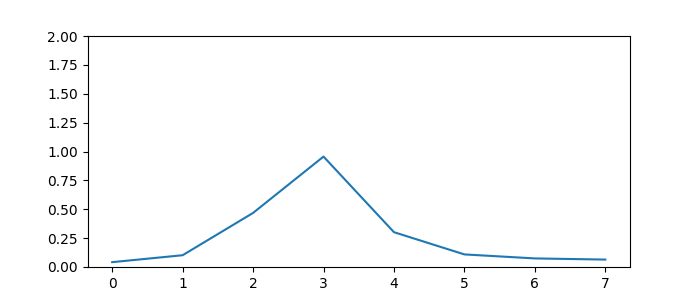

In [134]:
patch = stride_filtered[90,:,14,29]
plt.figure(figsize=(7,3))
plt.plot(patch)
plt.ylim(0,2)
plt.show()

<IPython.core.display.Javascript object>


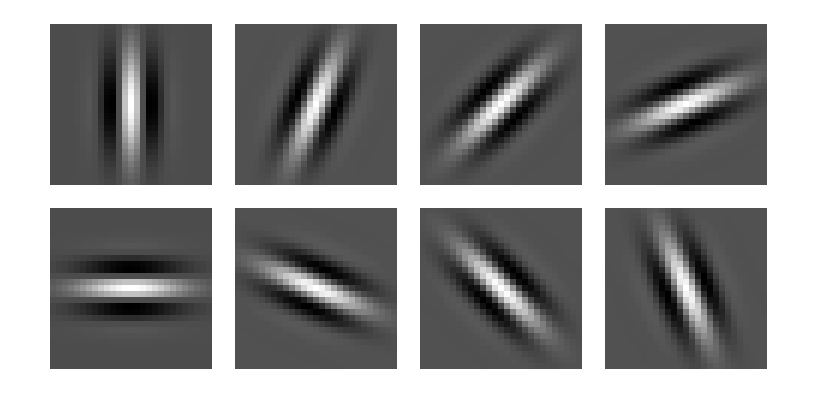

In [23]:
fig, axes = plt.subplots(2, 4, figsize=(9.5,2.5))
axes = axes.flatten()
for i in range(8):
    plt.sca(axes[i])
    plt.imshow(gabor_filters[i,:,:], cmap='gray')
    plt.axis('off')
#     gabors[i].plot()
plt.tight_layout()
plt.show()